In [2]:
using Revise
include("../src/classification.jl")
using Main.Classification
using Random
using PyCall
using Statistics

In [3]:
metrics = pyimport("sklearn.metrics");
Random.seed!(5);
function traintestsplit(X, y, splitratio, portion)
    if portion > size(X, 1)
        @warn "Data set too small; using all"
        portion = size(X, 1)
    end
    M = shuffle(1:length(y))
    traintest = splitratio*portion |> x -> round(Int, x)
    Xtrain = X[M, :][1:traintest, :]
    Ytrain = y[M][1:traintest]
    Xtest  = X[M, :][traintest+1:portion, :]
    Ytest  = y[M][traintest+1:portion];
    (Xtrain, Ytrain), (Xtest, Ytest)
end
#datasets = pyimport("sklearn.datasets")
#cancer = datasets.load_breast_cancer()
#set = cancer
#(Xtrain, Ytrain), (Xtest, Ytest) = traintestsplit(set["data"], set["target"], 0.8, 1000)

traintestsplit (generic function with 1 method)

In [181]:
sklsets = pyimport("sklearn.datasets")
observables, target = sklsets.make_classification(n_samples=5000, n_features=20, n_informative=15,
n_redundant=1, n_repeated=0, n_classes=2, random_state=1, flip_y=0.05, class_sep=1.0, shuffle=true)
(Xtrain, Ytrain), (Xtest, Ytest) = traintestsplit(observables, target, 0.8, 5000);

## Gradient Descent

In [4]:
gd = GDContext(learningrate=0.01, tolerance=1e-7, maxiterations=10000)
clf_gd = LogisticClassifier(GradientDescent(gd))
add_designmatrix!(clf_gd, Xtrain)
addvalidationset!(clf_gd, Xtest, Ytest)
@time fit!(clf_gd, Ytrain)
@show clf_gd.optimizer.converged

  3.508791 seconds (890.87 k allocations: 210.493 MiB, 3.40% gc time)
  5.498882 seconds (6.03 M allocations: 464.303 MiB, 4.32% gc time)
clf_gd.optimizer.converged = true


true

In [5]:
sgd = SGDContext(learningrate=0.01, tolerance=1e-9, maxiterations=1000, batchsize=100)
clf_sgd = LogisticClassifier(StochasticGradientDescent(sgd))
add_designmatrix!(clf_sgd, Xtrain)
addvalidationset!(clf_sgd, Xtest, Ytest, true)
@time fit!(clf_sgd, Ytrain)
@show clf_sgd.optimizer.converged

  0.382412 seconds (1.55 k allocations: 5.278 MiB, 1.54% gc time)
  0.382647 seconds (1.91 k allocations: 5.316 MiB, 1.54% gc time)
clf_sgd.optimizer.converged = false


false

In [6]:
nagd = NAGDContext(learningrate=0.01, tolerance=1e-9, maxiterations=1000, batchsize=100)
clf_nagd = LogisticClassifier(NesterovGradientDescent(nagd))
add_designmatrix!(clf_nagd, Xtrain)
addvalidationset!(clf_nagd, Xtest, Ytest, true)
@time fit!(clf_nagd, Ytrain)

@show clf_nagd.optimizer.converged

  0.033835 seconds (214 allocations: 826.719 KiB)
  0.043229 seconds (1.23 k allocations: 908.109 KiB)
clf_nagd.optimizer.converged = false


false

In [7]:
ŷ = predict(clf, Xtest)
metrics.accuracy_score(Ytest, ŷ) |> println
metrics.confusion_matrix(Ytest, ŷ) |> println
metrics.roc_auc_score(Ytest, ŷ) |> println
metrics.roc_curve(Ytest, ŷ) |> println

UndefVarError: UndefVarError: clf not defined

In [8]:
#using Gadfly
#using DataFrames

In [9]:
lm = pyimport("sklearn.linear_model")
logreg = lm.LogisticRegression().fit(Xtrain, Ytrain)
@show logreg.score(Xtrain, Ytrain)
@show logreg.score(Xtest, Ytest)
for clf in (clf_gd, clf_sgd, clf_nagd)
    @show score(clf, Xtrain, Ytrain)
    @show score(clf, Xtest, Ytest)
end

logreg.score(Xtrain, Ytrain) = 0.8475
logreg.score(Xtest, Ytest) = 0.855
score(clf, Xtrain, Ytrain) = 0.84925
score(clf, Xtest, Ytest) = 0.857
score(clf, Xtrain, Ytrain) = 0.8475
score(clf, Xtest, Ytest) = 0.858
score(clf, Xtrain, Ytrain) = 0.848
score(clf, Xtest, Ytest) = 0.857


In [10]:
using Plots

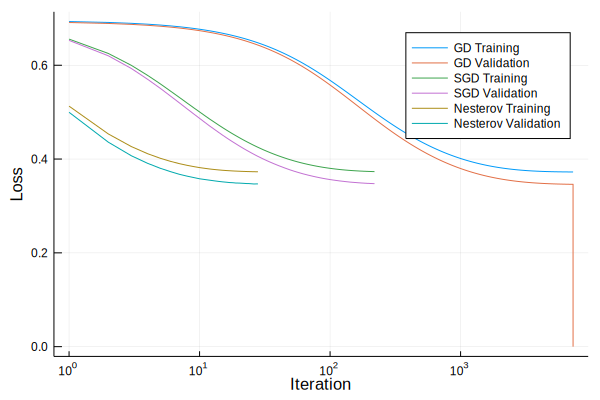

In [11]:
plot(clf_gd.optimizer.loss, label="GD Training", xscale=:log10)
plot!(clf_gd.optimizer.validationloss, label="GD Validation")
plot!(clf_sgd.optimizer.loss, label="SGD Training")
plot!(clf_sgd.optimizer.validationloss, label="SGD Validation", ylabel="Loss", xlabel="Iteration")
plot!(clf_nagd.optimizer.loss, label="Nesterov Training")
plot!(clf_nagd.optimizer.validationloss, label="Nesterov Validation")

## Neural Net

In [175]:
using Gadfly

In [196]:
net = NeuralNet([8, 6, 4, 1])
gd = GDContext(learningrate=0.01, maxiterations=1000)
optim = @time fit!(net, gd, Xtrain, Ytrain)


 10.208403 seconds (274.50 k allocations: 5.138 GiB, 14.67% gc time)


GradientDescent(GDContext(0.01, 2.220446049250313e-16, 1000), false, false, false, 1000, [0.6945754944271121, 0.6945761818452353, 0.6945768697346659, 0.6945775580958325, 0.694578246929164, 0.6945789362350901, 0.694579626014041, 0.6945803162664468, 0.6945810069927388, 0.6945816981933486  …  0.6955823106032265, 0.6955837913029843, 0.6955852733092331, 0.6955867566235074, 0.6955882412473442, 0.6955897271822833, 0.6955912144298655, 0.6955927029916357, 0.6955941928691391, 0.6955956840639249], ([0.0], Float64[]), Float64[])

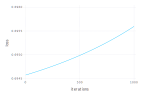

In [197]:
plt = plot(x = 1:length(optim.loss), y = optim.loss,
     Geom.line, Guide.xlabel("iterations"),
     Guide.ylabel("loss"))


In [193]:
function updateParameters!(unit::BackPropagationBatchLearningUnit, learningRate)
  forwardPass!(unit)
  backwardPass!(unit)
  derivativeW= (unit.deltas[1] * transpose(unit.dataBatch)) / size(unit.dataBatch,2);
  unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] - learningRate * derivativeW;
  derivativeB = mean(unit.deltas[1],2);
  unit.networkArchitecture.layers[1].parameters[:,end] =  unit.networkArchitecture.layers[1].parameters[:,end] - learningRate * derivativeB;
  for i in 2:(length(unit.networkArchitecture.layers) - 1)
    derivativeW = (unit.deltas[i] * transpose(unit.outputs[i-1])) / size(unit.dataBatch,2);
    unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] - learningRate * derivativeW;
    derivativeB = mean(unit.deltas[i],2);
    unit.networkArchitecture.layers[i].parameters[:,end] =  unit.networkArchitecture.layers[i].parameters[:,end] - learningRate * derivativeB;
  end
end

layer.b = [-0.06678024064792085, -0.05428136662036195, -0.01610454204742187, -0.014143754232028675, -0.14730710026883173, 0.038623970478844145, -0.06754237831696588, 0.02138310499636539]
layer.W = [-0.019370648554074558 0.08604049638461457 -0.07429757806347219 -0.01640332293179009 0.03645678068176737 0.06667525982409538 -0.06897074952608469 0.03283678903390792 0.01725703553232942 0.03933907323563387 0.05228054763713096 0.08037340213610755 -0.07577384586815732 0.12550751215225958 0.07924608416117251 -0.08097520331476923 -0.05496181952296513 0.13468839101664704 -0.08111403988289723 0.09537191710920725; 0.153950590092056 0.004385722924885486 0.07943027325271411 -0.007096903300072519 -0.03144325266824353 0.1433170394309445 0.08635106999559009 0.000932924563598705 -0.13446109979312848 0.08961110848580524 -0.12421116293595051 -0.06946568704048743 0.003967881064280612 0.010101588833534353 0.04127038184008128 0.09993656561987958 -0.152521543360738 -0.08873022521481436 -0.05883743756373498 -0.0

## Flux

In [1]:
using Flux

In [182]:
Xtrain, Ytrain = (Xtrain, Ytrain) .|> collect ∘ transpose;
Xtest, Ytest = (Xtest, Ytest) .|> collect ∘ transpose;

In [161]:
dataset = [(Xtrain[:, col], Ytrain[:, col])
           for col in 1:size(Xtrain, 2)];

In [171]:
#Random.seed!(5)
m = Chain(Dense(size(Xtrain, 1), 8, Flux.σ),
          Dense(8, 3, Flux.σ),
          Dense(3, 1, Flux.σ))
function lognull(x::T)::T where T<:Real
    x == zero(x) && return zero(x)
    log(x)
end
function crossloss(x, y)
    -mean(@. y* lognull(x) + (1-y) * lognull(1-x)) 
end
loss(x, y) = crossloss(m(x), y)
ps = Flux.params(m)
opt = Descent(0.1)
data = Iterators.repeat(dataset, 10)
evalcb = () -> @show(loss(Xtrain, Ytrain))
Flux.train!(loss, ps, data, opt, cb=Flux.throttle(evalcb, 1))

loss(Xtrain, Ytrain) = 0.77219f0 (tracked)
loss(Xtrain, Ytrain) = 0.52859175f0 (tracked)
loss(Xtrain, Ytrain) = 0.47147822f0 (tracked)
loss(Xtrain, Ytrain) = 0.4759851f0 (tracked)
loss(Xtrain, Ytrain) = 0.4296427f0 (tracked)
loss(Xtrain, Ytrain) = 0.43395647f0 (tracked)
loss(Xtrain, Ytrain) = 0.3664035f0 (tracked)
loss(Xtrain, Ytrain) = 0.37550092f0 (tracked)
loss(Xtrain, Ytrain) = 0.41863337f0 (tracked)
loss(Xtrain, Ytrain) = 0.35068318f0 (tracked)
loss(Xtrain, Ytrain) = 0.34537765f0 (tracked)
loss(Xtrain, Ytrain) = 0.35559f0 (tracked)
loss(Xtrain, Ytrain) = 0.3346201f0 (tracked)
loss(Xtrain, Ytrain) = 0.35047096f0 (tracked)
loss(Xtrain, Ytrain) = 0.34453854f0 (tracked)
loss(Xtrain, Ytrain) = 0.34089065f0 (tracked)
loss(Xtrain, Ytrain) = 0.32426006f0 (tracked)
loss(Xtrain, Ytrain) = 0.30902636f0 (tracked)
loss(Xtrain, Ytrain) = 0.32359412f0 (tracked)
loss(Xtrain, Ytrain) = 0.3448102f0 (tracked)
loss(Xtrain, Ytrain) = 0.29707524f0 (tracked)
loss(Xtrain, Ytrain) = 0.33720508f0 (tracked)

In [173]:
@show loss(Xtrain, Ytrain)
accuracy(x, y) = mean(Int.(m(x) .> 0.5) .== y)
@show accuracy(Xtrain, Ytrain)
@show accuracy(Xtest, Ytest)

loss(Xtrain, Ytrain) = 0.22983222f0 (tracked)
accuracy(Xtrain, Ytrain) = 0.924
accuracy(Xtest, Ytest) = 0.928


0.928

In [189]:
params(m)

Params([Float32[0.0030425296 -1.0176951 … -1.3473097 1.7433305; -2.893303 -5.5520554 … -3.013224 0.09153573; … ; -3.3543499 0.82601804 … -0.98845595 0.5768681; 0.3830294 -0.39257544 … -0.70263535 -0.18486263] (tracked), Float32[-7.138194, 3.4904063, -1.5153009, 1.0759685, -1.1101475, 0.5765437, 1.7226937, 2.2809253] (tracked), Float32[1.9876704 1.3635588 … -0.569468 -1.5454066; 5.962072 -1.3463403 … 1.5441022 2.2029068; 0.55174804 4.0852413 … -2.6766326 -1.4369813] (tracked), Float32[-2.475815, 1.4103218, 1.7953079] (tracked), Float32[-5.2913303 -3.3015797 4.772897] (tracked), Float32[-0.20712693] (tracked)])

In [158]:
X = randn(1, 500)
y = 
m = Chain(Dense(1, 1), Flux.σ)
loss(x, y) = Flux.crossentropy(m(x), y)
ps = Flux.params(m)
opt = Descent(0.1)
data = Iterators.repeat([(X, y)], 10000)
evalcb = () -> @show(loss(X, y))
Flux.train!(loss, ps, data, opt, cb=Flux.throttle(evalcb, 1))

ErrorException: Use broadcasting (`σ.(x)`) to apply activation functions to arrays.

In [156]:
(m(X) .> 0.3) .- y |> sum

270 (tracked)

In [157]:
params(m)

Params([Float32[3.1347864] (tracked), Float32[4.120028] (tracked)])

In [127]:
data, labels = rand(10, 1000), fill(0.5, 2, 1000)
m = Chain(Dense(10, 5, relu), Dense(5, 2), softmax)
loss(x, y) = sum(Flux.crossentropy(m(x), y))
set = Iterators.repeat([(data, labels)], 100)
Flux.train!(loss, params(m), set, opt)

In [131]:
m(data)

Tracked 2×1000 Array{Float32,2}:
 0.467076  0.556963  0.532615  0.491792  …  0.548434  0.523084  0.469489
 0.532924  0.443037  0.467385  0.508208     0.451566  0.476916  0.530511

In [142]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
# using CuArrays

# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) |> gpu

m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) |> gpu

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))

accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

accuracy(tX, tY)

┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/erdos/.julia/packages/Flux/dkJUV/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/erdos/.julia/packages/Flux/dkJUV/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/erdos/.julia/packages/Flux/dkJUV/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/erdos/.julia/packages/Flux/dkJUV/src/data/mnist.jl:24


loss(X, Y) = 2.3561985f0 (tracked)
loss(X, Y) = 1.3558338f0 (tracked)
loss(X, Y) = 0.7684905f0 (tracked)
loss(X, Y) = 0.5347053f0 (tracked)
loss(X, Y) = 0.44027382f0 (tracked)
loss(X, Y) = 0.39577278f0 (tracked)
loss(X, Y) = 0.3594746f0 (tracked)
loss(X, Y) = 0.33074448f0 (tracked)
loss(X, Y) = 0.31280208f0 (tracked)
loss(X, Y) = 0.29883856f0 (tracked)
loss(X, Y) = 0.284901f0 (tracked)


0.9234

In [145]:
onecold(m(X))

60000-element Array{Int64,1}:
  6
  1
  5
  2
 10
  3
  2
  4
  2
  5
  4
  6
  4
  ⋮
  8
  9
 10
  3
 10
  6
  2
  9
  4
  6
  7
  9

# Notes

- Learning using `accuracy` is waaay worse than `logcrossentropy`
- Implement
  - Summary
  - Early stopping
- Find a better data set

## 